In [1]:
# Fangjun Hu

# Preamble
import numpy as np
import math
import scipy
import random
import matplotlib.pyplot as plt
import scipy.linalg as la

from scipy.integrate import ode
from scipy.integrate import odeint
from scipy.linalg import expm, logm, sinm, cosm, svd, hadamard
from scipy.optimize import minimize, fsolve, root # minimization

from numpy.linalg import matrix_rank
from sklearn import svm
from sklearn import linear_model
from copy import deepcopy

# Import qutip
from qutip import *
from qutip.expect import expect_rho_vec

import time

# Font
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)


In [2]:
params = {'axes.labelsize': '50',
    'axes.titlesize':'50',
    'xtick.labelsize':'50',
    'ytick.labelsize':'50',
    'lines.linewidth' : 4,
    'legend.fontsize': '40',
    'xtick.major.size': 40.,
    'ytick.major.size': 40.,
    'xtick.minor.size': 20.,
    'ytick.minor.size': 20.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])

In [3]:
# extra minimization
from sklearn import linear_model
# from skopt.utils import use_named_args
# from skopt.space import Real as spaceReal
# from skopt import gp_minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import math
import h5py

# 1. Generating the Channel Equalization Messages

In [4]:
def EC_Analysis(Output_Feature):
    
    N, K       = Output_Feature.shape                     # Feature matrix of N input data, with K=2^L features
    
    G          = Output_Feature.T @ Output_Feature/N
    D          = np.diag(np.sum(G, axis=0))
    RandomWalk = la.pinv(D) @ G
    
    alpha, r   = la.eig(RandomWalk)
    index      = alpha.argsort()[::-1]
    alpha_sort = np.real(alpha[index])
    r_sort     = np.real(r[:, index])
    nsr        = (1-alpha_sort)/alpha_sort
    
    return nsr, r_sort

In [5]:
def coerce(data):
    """Naively round to the nearest 4PAM symbol."""
    data[np.where(data>=2.0)]  =  3.0
    data[np.where(np.logical_and(data>=0.0, data<2.0))]  =  1.0
    data[np.where(np.logical_and(data>=-2.0, data<0.0))]  = -1.0
    data[np.where(data<=-2.0)] = -3.0
    return data

def Tikhonov_Regularization(X, y, lmd):
    w = np.linalg.solve((X.T @ X + lmd * np.identity(np.shape(X)[1])), X.T @ y)
    return w

def RMSE(w, X, y):
    (m, n) = np.shape(y)
    return np.sqrt((1/(m*n))*np.linalg.norm(y-X@w)**2)


In [6]:
# CE task parameters

SNR = 20. # SNR ratio for CE data
rseed =  17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = 17462) # random number generator

# sampling times for reservoir
tS = 1e-3 # timestep
Thold = 1. # time hold each symbol for

# Convolution Kernel: channel coefficients
chan_coefs = [1.0, 0.18, -0.1, +0.091, -0.05, +0.04, +0.03, +0.01]
N_coefs = len(chan_coefs)

In [7]:
Nsymb_tr = 100 # length of CE dataset (symbols)

tI, tF_tr, nS_tr, nhold = 0, Thold*Nsymb_tr, int(Thold*Nsymb_tr/tS), int(Thold/tS)
tList_tr = np.linspace(tI, tF_tr, nS_tr, endpoint=False)
tsymb_tr = np.linspace(tI, tF_tr, Nsymb_tr, endpoint=False)

# generate true CE data for Training
N_train = 100
MessageSetSymb_train = []
MessageSet_train = []
InputSetSymb_train = []
InputSet_train = []
for r in range(N_train):  
    Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb_tr) - 3 # random integers [-3, -1, 1, 3]
    Y_sig = (Y_symb[:, np.newaxis] @ np.ones((1, int(Thold/tS)))).flatten() # sample at each time point 
    MessageSetSymb_train.append(Y_symb)
    MessageSet_train.append(Y_sig)
    
    f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
    Nscale = np.sqrt(10.0**(-SNR/10.0))
    u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb_tr) # add nonlinearity and noise
    u_sig = (u_symb[:, np.newaxis] @ np.ones((1, nhold))).flatten() # sample at each time point
    InputSetSymb_train.append(u_symb)
    InputSet_train.append(u_sig)
    
MessageSetSymb_train = np.array(MessageSetSymb_train)
MessageSet_train = np.array(MessageSet_train)
InputSetSymb_train = np.array(InputSetSymb_train)

MessageSetSymb_train.shape, MessageSet_train.shape, InputSetSymb_train.shape

((100, 100), (100, 100000), (100, 100))

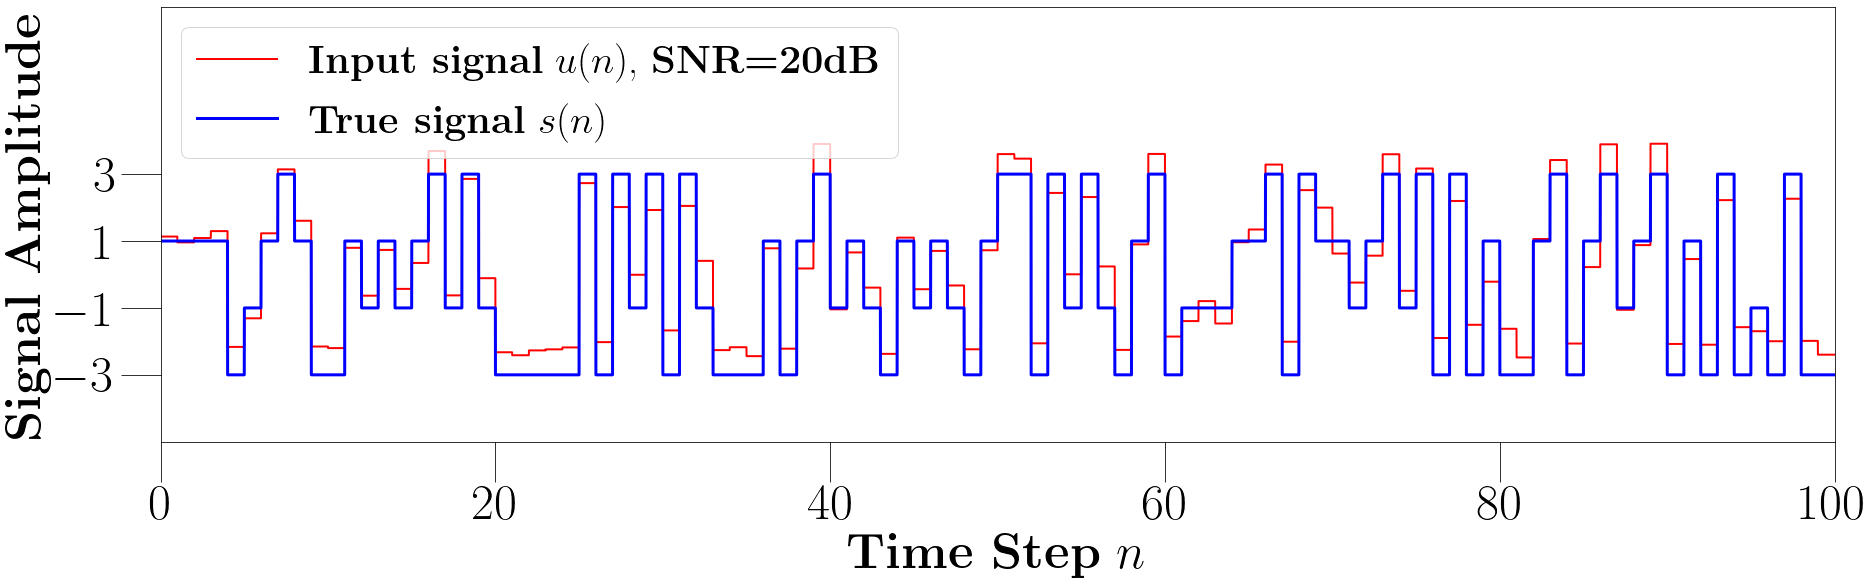

In [8]:
# visualize CE task
fig_CEt, axes = plt.subplots(1, 1, figsize=(30, 8))
ax_CEt = axes
ax_CEt.plot(tList_tr, InputSet_train[0], '-r', linewidth=2, label = '\\textbf{Input signal} $u(n)$, \\textbf{SNR=20dB}')
ax_CEt.plot(tList_tr, MessageSet_train[0], 'b', linewidth=3, label = '\\textbf{True signal} $s(n)$')
ax_CEt.set_xlim([tI, tF_tr])
ax_CEt.set_ylim([-5, 8])
ax_CEt.set_yticks([-3, -1, 3, 1])
ax_CEt.set_ylabel('\\textbf{Signal Amplitude}')
ax_CEt.set_xlabel('\\textbf{Time Step} $n$')
ax_CEt.legend()
# ax_CEt[1].hist(u_sig, bins=40, density=True);
# ax_CEt[1].set_xlim([min(u_sig), max(u_sig)])
# ax_CEt[1].set_ylabel('Signal Distribution')
# ax_CEt[1].set_xlabel('Signal Amplitude')
# plt.title('\\textbf{SNR = 20 dB}')


# 2. System for Quantum RC Simulation

In [9]:
def Classical_Entropy(eig_list):
    Entropy = 0
    for i in range(len(eig_list)): 
        if eig_list[i] !=0: 
            Entropy = Entropy - eig_list[i] * np.log(eig_list[i])/np.log(2)
    return Entropy


# Pauli Matrices 

σ_x = np.array([[0,   1], [1 ,  0]]) 
σ_y = np.array([[0, -1j], [1j,  0]]) 
σ_z = np.array([[1,   0], [0 , -1]])
I_2 = np.identity(2, dtype=int)

g = np.array([[0, 0], [0, 1]])
e = np.array([[1, 0], [0, 0]])

ψg = basis(2, 0)
ρg = ψg*ψg.dag()

ψe = basis(2, 1)
ρe = ψe*ψe.dag()


In [10]:
N_system  = 2
N_ancilla = 4
N_qubits  = N_system + N_ancilla

X_op = []  # Defined on all qubits
for i in range(N_qubits):
    X = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            X = tensor(X, sigmax())
        else: 
            X = tensor(X, qeye(2))
    X = X.ptrace(range(1, N_qubits + 1))
    X_op.append(X)

Z_op = []  # Defined on all qubits
for i in range(N_qubits):
    Z = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            Z = tensor(Z, sigmaz())
        else: 
            Z = tensor(Z, qeye(2))
    Z = Z.ptrace(range(1, N_qubits + 1))
    Z_op.append(Z)
    
C_op = []  # Defined on all qubits
for i in range(N_qubits):
    C = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            C = tensor(C, create(2))
        else: 
            C = tensor(C, qeye(2))
    C = C.ptrace(range(1, N_qubits + 1))
    C_op.append(C)
    
D_op = []  # Defined on all qubits
for i in range(N_qubits):
    D = qeye(1)
    for j in range(N_qubits): 
        if j == i:
            D = tensor(D, destroy(2))
        else: 
            D = tensor(D, qeye(2))
    D = D.ptrace(range(1, N_qubits + 1))
    D_op.append(D)

len(X_op), len(Z_op), len(C_op), len(D_op)


(6, 6, 6, 6)

In [11]:
M_op = []  # Defined on all qubits
for k in range(2**N_ancilla):
    M = np.zeros((2**N_ancilla, 2**N_ancilla))
    M[k, k] = 1
    M = np.kron(np.eye(2**N_system), M)
    Op = Qobj(M, dims = [[2]*N_qubits, [2]*N_qubits], shape = (2**N_qubits, 2**N_qubits))
    M_op.append(Op)
    
len(M_op)


16

In [55]:
rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

hx0_vec = (1.0 + 1.0*rs.randn(N_qubits)) * 2
hz1_vec = (1.0 + 1.0*rs.randn(N_qubits)) * 0.5

J_graph = np.zeros((N_qubits, N_qubits))

# Jacobian Rank = 15, Complete graph
for i in range(N_qubits):
    for j in range(N_qubits): 
        if i < j: J_graph[i, j] = 1

# Jacobian Rank = 6
# J_graph = np.array([[0, 0, 1, 1, 0, 0],
#                     [0, 0, 0, 0, 1, 1],
#                     [0, 0, 0, 1, 0, 0],
#                     [0, 0, 0, 0, 0, 0],
#                     [0, 0, 0, 0, 0, 1],
#                     [0, 0, 0, 0, 0, 0]])


# J_mat = np.random.rand(N_qubits, N_qubits)
J_mat = 0 + 1*rs.rand(N_qubits, N_qubits)
J_mat = J_mat * J_graph * 1

γ_vec = 0 + 0.0*np.random.randn(N_qubits)

print(f'J_mat = \n{J_mat},\nhx0_vec = \n {hx0_vec},\nhz1_vec = \n {hz1_vec},\nγ_vec = \n {γ_vec}. ')


J_mat = 
[[0.         0.         0.89006318 0.86850316 0.         0.        ]
 [0.         0.         0.         0.         0.92737587 0.74393229]
 [0.         0.         0.         0.98246317 0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.77647338]
 [0.         0.         0.         0.         0.         0.        ]],
hx0_vec = 
 [ 4.11748075 -0.45826656  1.42274439  1.5034131   2.39780448  1.81595912],
hz1_vec = 
 [0.71612037 0.51032864 0.11944237 0.34561147 0.32480181 0.16499771],
γ_vec = 
 [0. 0. 0. 0. 0. 0.]. 


In [56]:
# Encode H0

H0 = 0
for i in range(N_qubits):
    H0 = H0 + hx0_vec[i] * X_op[i]
for i in range(N_qubits):
    for j in range(N_qubits):
        H0 = H0 + J_mat[i, j] * Z_op[i] * Z_op[j]
        
# Encode H1

H1 = 0
for i in range(N_qubits):
    H1 = H1 + hz1_vec[i] * Z_op[i]

def Hamiltonian_Encoding(u): 
    return H0 + u*H1

def Ad(H, ρ):
    return H * ρ - ρ * H

def DT(ρ):
    S = 0
    for i in range(N_qubits):
        S = S + γ_vec[i] * (D_op[i]*ρ*C_op[i] - 0.5*C_op[i]*D_op[i]*ρ - 0.5*ρ*C_op[i]*D_op[i])
    return 1j * S


Total time = 0.061 s.


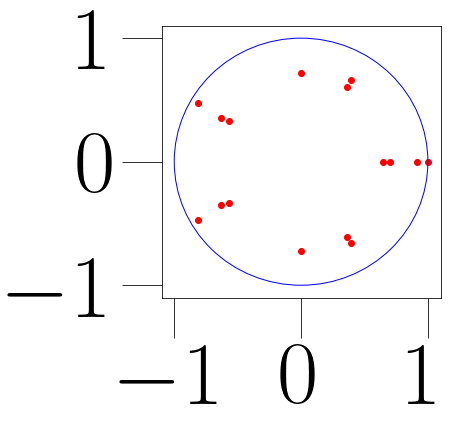

(array([0.64265, 0.6568 , 0.6568 , 0.7001 , 0.70489, 0.70489, 0.72041,
        0.72041, 0.72041, 0.72041, 0.7679 , 0.7679 , 0.91794, 0.93816,
        0.93816, 1.     ]),
 10.857942363926087)

In [57]:
sT = time.time()

τ = 1.0

U0  = (- 1j * τ * H0).expm()
U0D = (+ 1j * τ * H0).expm()

Pauli_Basis  = [qeye(2), sigmax(), sigmay(), sigmaz()]
Pauli_String = []

for i in range(4**N_system): 
    string = np.base_repr(i, base=4)
    string = '0'*(N_system-len(string))+string
    tsr = qeye(1)
    for j in range(N_system): 
        tsr = tensor(tsr, Pauli_Basis[int(string[j])])
    tsr = tsr.ptrace(range(1, N_system+1))
    Pauli_String.append(tsr)
        
Trans = np.zeros((4**(N_system), 4**(N_system)))

for i in range(4**(N_system)): 
    
    if (i+1)%100 == 0: 
        print(f'For {i+1}-th Pauli string, elapsed time = {np.round(time.time() - sT, 3)} s.')
    ρS = Pauli_String[i]
    ρSE = ρS
    for r in range(N_ancilla):
        ρSE = tensor(ρSE, ρg)
    ρSE = U0 * ρSE * U0D
    ρS = ρSE.ptrace(range(N_system))
    
    for j in range(4**(N_system)): 
        Trans[j, i] = np.real((np.array(ρS) @ np.array(Pauli_String[j])).trace())/2**(N_system)

print(f'Total time = {np.round(time.time() - sT, 3)} s.') # ρFP

fig,ax = plt.subplots(1, 1, figsize=(5, 5))
circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
ax.add_patch(circ)
plt.scatter(np.real(la.eigvals(Trans)), np.imag(la.eigvals(Trans)), color='red')
plt.show()

norm_list = np.sort(np.abs(la.eigvals(Trans)))
np.round(norm_list, 5), np.log(0.5)/np.log(norm_list[-2])


/Users/hufangjun/opt/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/axes3d.py:2605: ComplexWarning: Casting complex values to real discards the imaginary part
  polys[..., i] = p + dp * cuboid[..., i]
/Users/hufangjun/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


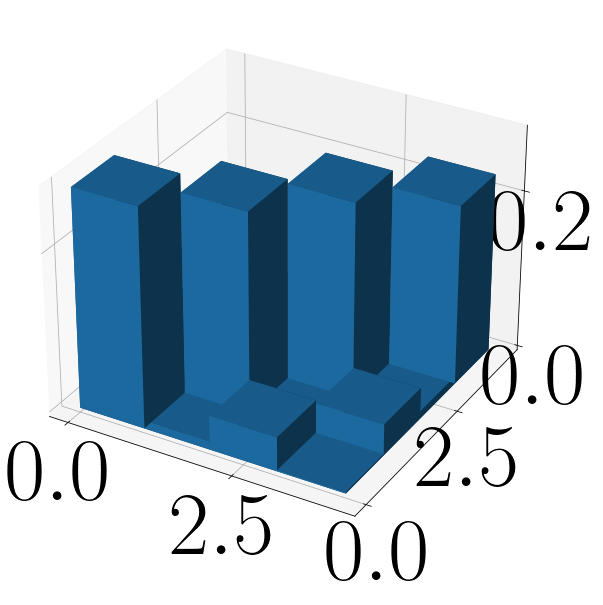

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.27566246+0.j         0.01040166+0.00678231j 0.04299457-0.00182012j
  0.00166711+0.00098914j]
 [0.01040166-0.00678231j 0.25238232+0.j         0.00157755-0.0011265j
  0.03936361-0.00166641j]
 [0.04299457+0.00182012j 0.00157755+0.0011265j  0.24638125+0.j
  0.00929679+0.00606188j]
 [0.00166711-0.00098914j 0.03936361+0.00166641j 0.00929679-0.00606188j
  0.22557396+0.j        ]]

In [58]:
A = Trans[1:, 1:]
b = Trans[1:, 0 ]

U, S, V = la.svd(A, full_matrices=False, compute_uv=True)
x = la.solve(np.eye(4**(N_system)-1) - A, b)
# print(A @ x + b - x)

ρ_Tomo = 0
for i in range(1, 4**(N_system)):
    ρ_Tomo = ρ_Tomo + x[i-1] * Pauli_String[i]
    
ρFP = (ρ_Tomo + Qobj(np.eye(2**(N_system)), dims = [[2]*(N_system), [2]*(N_system)]))/(2**(N_system))

matrix = np.array(ρFP)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
xpos = [range(matrix.shape[0])]
ypos = [range(matrix.shape[1])]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)
dx = np.ones_like(zpos)
dy = dx.copy()
dz = matrix.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

# eig_list = np.round(ρFP.eigenenergies(), 3)
# print(Classical_Entropy(eig_list), N_system)

ρFP


# 3. Vary SNR

In [59]:
np.linspace(0, 25, 6)
ρ0 = qeye(1)
for i in range(N_system): 
    ρ0 = tensor(ρ0, ρg)
ρ0 = ρ0.ptrace(range(1, N_system+1)) # Reduce dims
ρ0, ρFP


(Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0.27566246+0.j         0.01040166+0.00678231j 0.04299457-0.00182012j
   0.00166711+0.00098914j]
  [0.01040166-0.00678231j 0.25238232+0.j         0.00157755-0.0011265j
   0.03936361-0.00166641j]
  [0.04299457+0.00182012j 0.00157755+0.0011265j  0.24638125+0.j
   0.00929679+0.00606188j]
  [0.00166711-0.00098914j 0.03936361+0.00166641j 0.00929679-0.00606188j
   0.22557396+0.j        ]])

In [60]:
def qubit(b):
    if b==0: qb = np.array([1, 0])
    if b==1: qb = np.array([0, 1])
    return qb

def Cov(L, Prob): 
    Sigma = np.diag(Prob) - np.array([Prob]).T @ np.array([Prob])
    return Sigma

def XtoPl(L, Prob):
    Pl = np.zeros((2, L))
    rho = Qobj(np.diag(Prob), dims = [[2]*L, [2]*L], shape = (2**L, 2**L))
    for l in range(L):
        Pl[:, l] = np.real(np.diag(rho.ptrace(l)))
    return Pl

def XtoZ(L, Prob):
    K = 2**L
    Pl = XtoPl(L, Prob)
    Z = 1
    for l in range(L): 
        Z = np.kron(Z, Pl[:, l])
    H = hadamard(K)
    return H @ Z

def binary(L, b):
    string = np.base_repr(b, base=2)
    string = '0'*(L-len(string))+string
    return string

def Grad(L, k, Prob, Pl): 
    K = 2**L
    string = binary(L, k)
    grad = np.zeros(K)
    for i1 in range(L):
        temp = 1
        for i2 in range(L):
            if i2 == i1:
                temp = np.kron(temp, qubit(int(string[i1])))
            else:
                temp = np.kron(temp, Pl[:, i2])
        grad = grad + temp
    H = hadamard(K)
    return H @ grad

def Hess(L, k1, k2, Prob, Pl): 
    K = 2**L
    string1 = binary(L, k1)
    string2 = binary(L, k2)
    hess = np.zeros(K)
    for i1 in range(L):
        for i2 in range(L):
            if i2 != i1:
                temp = 1
                for i3 in range(L):
                    if i3 == i1:
                        temp = np.kron(temp, qubit(int(string1[i1])))
                    elif i3 == i2:
                        temp = np.kron(temp, qubit(int(string2[i2])))
                    else:
                        temp = np.kron(temp, Pl[:, i3])
                hess = hess + temp
    H = hadamard(K)
    return H @ hess


# 3.1 Fully Connected QRC, $R_j = 15$ and $S = \infty$

To simulate this Section, one need to set the connectivity be the one with Jacobian rank 15 in Section 2.

In [50]:
sT = time.time()

# CE task parameters
Nsymb = 100 # length of CE dataset (symbols)
SNR_list = np.linspace(0, 25, 6)
rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

# Convolution Kernel: channel coefficients
chan_coefs = [1.0, 0.18, -0.1, +0.091, -0.05, +0.04, +0.03, +0.01]
N_coefs = len(chan_coefs)

N_of = int(2**N_ancilla)
nS_max = int(1e5)

### Traning

Error_list_train = []
Error_list_test  = []

Error_list_classical_train = []
Error_list_classical_test  = []

for SNR in SNR_list:
    
    print(f'SNR = {SNR}, elapsed time = {np.round(time.time() - sT, 3)} s.')
    Nscale = np.sqrt(10.0**(-SNR/10.0))
    
    # generate true CE data for Training
    N_train = 100
    MessageSetSymb_train = []
    InputSetSymb_train = []
    for r in range(N_train):  
        Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb) - 3 # random integers [-3, -1, 1, 3]
        MessageSetSymb_train.append(Y_symb)

        f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
        u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb) # add nonlinearity and noise
        InputSetSymb_train.append(u_symb)

    MessageSetSymb_train = np.array(MessageSetSymb_train)
    InputSetSymb_train = np.array(InputSetSymb_train)

    # generate true CE data for Training
    N_test = 100
    MessageSetSymb_test = []
    InputSetSymb_test = []
    for r in range(N_test):  
        
        Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb) - 3 # random integers [-3, -1, 1, 3]
        MessageSetSymb_test.append(Y_symb)

        f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
        u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb) # add nonlinearity and noise
        InputSetSymb_test.append(u_symb)

    MessageSetSymb_test = np.array(MessageSetSymb_test)
    InputSetSymb_test = np.array(InputSetSymb_test)
    
    
    Output_Feature_train = np.zeros((N_train, Nsymb, N_of))
    
    for r in range(N_train):
        if (r+1)%25 == 0: 
                print(f'For {r+1}-th training message, elapsed time = {np.round(time.time() - sT, 3)} s.')
        # State initialization
        ρS  = ρFP
        ρSE = ρS
        for i in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        for t in range(Nsymb):
            # 1. Apply unitrary evolution on SE qubits
            H = Hamiltonian_Encoding(InputSetSymb_train[r, t])
            # output = mesolve(H, ρSE, tlist)
            ρSE = (- 1j * τ * H).expm() * ρSE * (+ 1j * τ * H).expm()
            # 2. Partial readout
            ρS = ρSE.ptrace(range(N_system))
            ρE = ρSE.ptrace(range(N_system, N_qubits))
            Prob = np.real(np.diag(np.array(ρE)))
            Prob = Prob/np.sum(Prob)
            Output_Feature_train[r, t] = Prob                                   ### S-infinite, Prob. Rep.
#             Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))     ### S-finite, Prob. Rep.
#             for k in range(N_of):
#                 Output_Feature_train[r, t, k] = (Coins==k).sum()/nS_max
            # 3. Reseting
            ρSE = ρS
            for i in range(N_ancilla):
                ρSE = tensor(ρSE, ρg)
    
    Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of))
    MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))
    
    Output_Feature_test = np.zeros((N_test, Nsymb, N_of))
    for r in range(N_test):
        if (r+1)%25 == 0: 
                print(f'For {r+1}-th testing message, elapsed time = {np.round(time.time() - sT, 3)} s.')
        # State initialization
        ρS  = ρFP
        ρSE = ρS
        for i in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        for t in range(Nsymb):
            # 1. Apply unitrary evolution on SE qubits
            H = Hamiltonian_Encoding(InputSetSymb_test[r, t])
            # output = mesolve(H, ρSE, tlist)
            ρSE = (- 1j * τ * H).expm() * ρSE * (+ 1j * τ * H).expm()
            # 2. Partial readout
            ρS = ρSE.ptrace(range(N_system))
            ρE = ρSE.ptrace(range(N_system, N_qubits))
            Prob = np.real(np.diag(np.array(ρE)))
            Prob = Prob/np.sum(Prob)
            Output_Feature_test[r, t] = Prob                                    ### S-infinite, Prob. Rep.
#             Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))     ### S-finite, Prob. Rep.
#             for k in range(N_of):                                             
#                 Output_Feature_test[r, t, k] = (Coins==k).sum()/nS_max        
            # 3. Reseting
            ρSE = ρS
            for i in range(N_ancilla):
                ρSE = tensor(ρSE, ρg)
    
    Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of))
    MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))
    
    
    lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)
#     lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'none', max_iter=500)
    lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
    accuracy = lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) 
    Error_list_train.append(1 - accuracy)
    accuracy = lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0])
    Error_list_test.append(1 - accuracy)
    print(f'SNR = {SNR}, error rate = {1 - accuracy} (Quantum Readout)')
    
Error_list_QRC_Connected_train = Error_list_train
Error_list_QRC_Connected_test  = Error_list_test
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')


SNR = 0.0, elapsed time = 0.002 s.
For 25-th training message, elapsed time = 17.771 s.
For 50-th training message, elapsed time = 35.553 s.
For 75-th training message, elapsed time = 54.365 s.
For 100-th training message, elapsed time = 72.601 s.
For 25-th testing message, elapsed time = 91.553 s.
For 50-th testing message, elapsed time = 110.221 s.
For 75-th testing message, elapsed time = 128.744 s.
For 100-th testing message, elapsed time = 147.176 s.
SNR = 0.0, error rate = 0.30269999999999997 (Quantum Readout)
SNR = 5.0, elapsed time = 150.044 s.
For 25-th training message, elapsed time = 166.92 s.
For 50-th training message, elapsed time = 185.127 s.
For 75-th training message, elapsed time = 203.465 s.
For 100-th training message, elapsed time = 221.47 s.
For 25-th testing message, elapsed time = 239.935 s.
For 50-th testing message, elapsed time = 259.898 s.
For 75-th testing message, elapsed time = 278.765 s.
For 100-th testing message, elapsed time = 297.706 s.
SNR = 5.0, er

# 3.2 Splited QRC, $R_j = 6$ and $S = \infty$

To simulate this Section, one need to set the connectivity be the one with Jacobian rank 6 in Section 2.

In [68]:
sT = time.time()

# CE task parameters
Nsymb = 100 # length of CE dataset (symbols)
SNR_list = np.linspace(0, 25, 6)
rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

# Convolution Kernel: channel coefficients
chan_coefs = [1.0, 0.18, -0.1, +0.091, -0.05, +0.04, +0.03, +0.01]
N_coefs = len(chan_coefs)

N_of = int(2**N_ancilla)
nS_max = int(1e5)

### Traning

Error_list_train = []
Error_list_test  = []

Error_list_classical_train = []
Error_list_classical_test  = []

for SNR in SNR_list:
    
    print(f'SNR = {SNR}, elapsed time = {np.round(time.time() - sT, 3)} s.')
    Nscale = np.sqrt(10.0**(-SNR/10.0))
    
    # generate true CE data for Training
    N_train = 100
    MessageSetSymb_train = []
    InputSetSymb_train = []
    for r in range(N_train):  
        Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb) - 3 # random integers [-3, -1, 1, 3]
        MessageSetSymb_train.append(Y_symb)

        f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
        u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb) # add nonlinearity and noise
        InputSetSymb_train.append(u_symb)

    MessageSetSymb_train = np.array(MessageSetSymb_train)
    InputSetSymb_train = np.array(InputSetSymb_train)

    # generate true CE data for Training
    N_test = 100
    MessageSetSymb_test = []
    InputSetSymb_test = []
    for r in range(N_test):  
        
        Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb) - 3 # random integers [-3, -1, 1, 3]
        MessageSetSymb_test.append(Y_symb)

        f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
        u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb) # add nonlinearity and noise
        InputSetSymb_test.append(u_symb)

    MessageSetSymb_test = np.array(MessageSetSymb_test)
    InputSetSymb_test = np.array(InputSetSymb_test)
    
    
    Output_Feature_train = np.zeros((N_train, Nsymb, N_of))
    
    for r in range(N_train):
        if (r+1)%25 == 0: 
                print(f'For {r+1}-th training message, elapsed time = {np.round(time.time() - sT, 3)} s.')
        # State initialization
        ρS  = ρFP
        ρSE = ρS
        for i in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        for t in range(Nsymb):
            # 1. Apply unitrary evolution on SE qubits
            H = Hamiltonian_Encoding(InputSetSymb_train[r, t])
            # output = mesolve(H, ρSE, tlist)
            ρSE = (- 1j * τ * H).expm() * ρSE * (+ 1j * τ * H).expm()
            # 2. Partial readout
            ρS = ρSE.ptrace(range(N_system))
            ρE = ρSE.ptrace(range(N_system, N_qubits))
            Prob = np.real(np.diag(np.array(ρE)))
            Prob = Prob/np.sum(Prob)
            Output_Feature_train[r, t] = Prob                                   ### S-infinite, Prob. Rep.
#             Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))     ### S-finite, Prob. Rep.
#             for k in range(N_of):
#                 Output_Feature_train[r, t, k] = (Coins==k).sum()/nS_max
            # 3. Reseting
            ρSE = ρS
            for i in range(N_ancilla):
                ρSE = tensor(ρSE, ρg)
    
    Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of))
    MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))
    
    Output_Feature_test = np.zeros((N_test, Nsymb, N_of))
    for r in range(N_test):
        if (r+1)%25 == 0: 
                print(f'For {r+1}-th testing message, elapsed time = {np.round(time.time() - sT, 3)} s.')
        # State initialization
        ρS  = ρFP
        ρSE = ρS
        for i in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        for t in range(Nsymb):
            # 1. Apply unitrary evolution on SE qubits
            H = Hamiltonian_Encoding(InputSetSymb_test[r, t])
            # output = mesolve(H, ρSE, tlist)
            ρSE = (- 1j * τ * H).expm() * ρSE * (+ 1j * τ * H).expm()
            # 2. Partial readout
            ρS = ρSE.ptrace(range(N_system))
            ρE = ρSE.ptrace(range(N_system, N_qubits))
            Prob = np.real(np.diag(np.array(ρE)))
            Prob = Prob/np.sum(Prob)
            Output_Feature_test[r, t] = Prob                                    ### S-infinite, Prob. Rep.
#             Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))     ### S-finite, Prob. Rep.
#             for k in range(N_of):                                             
#                 Output_Feature_test[r, t, k] = (Coins==k).sum()/nS_max        
            # 3. Reseting
            ρSE = ρS
            for i in range(N_ancilla):
                ρSE = tensor(ρSE, ρg)
    
    Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of))
    MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))
    
    
    lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)
#     lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'none', max_iter=500)
    lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
    accuracy = lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) 
    Error_list_train.append(1 - accuracy)
    accuracy = lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0])
    Error_list_test.append(1 - accuracy)
    print(f'SNR = {SNR}, error rate = {1 - accuracy} (Quantum Readout)')
    
Error_list_QRC_22_train = Error_list_train
Error_list_QRC_22_test  = Error_list_test
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')


SNR = 0.0, elapsed time = 0.002 s.
For 25-th training message, elapsed time = 18.328 s.
For 50-th training message, elapsed time = 36.953 s.
For 75-th training message, elapsed time = 57.052 s.
For 100-th training message, elapsed time = 75.522 s.
For 25-th testing message, elapsed time = 94.816 s.
For 50-th testing message, elapsed time = 114.801 s.
For 75-th testing message, elapsed time = 134.948 s.
For 100-th testing message, elapsed time = 153.284 s.
SNR = 0.0, error rate = 0.3146 (Quantum Readout)
SNR = 5.0, elapsed time = 157.679 s.
For 25-th training message, elapsed time = 176.122 s.
For 50-th training message, elapsed time = 196.069 s.
For 75-th training message, elapsed time = 215.982 s.
For 100-th training message, elapsed time = 234.999 s.
For 25-th testing message, elapsed time = 256.177 s.
For 50-th testing message, elapsed time = 275.441 s.
For 75-th testing message, elapsed time = 293.641 s.
For 100-th testing message, elapsed time = 311.73 s.
SNR = 5.0, error rate = 0

# 3.3 Fully Connected QRC, $R_j = 15$ and $S = 10^5$

To simulate this Section, one need to set the connectivity be the one with Jacobian rank 15 in Section 2.

In [31]:
sT = time.time()

# CE task parameters
Nsymb = 100 # length of CE dataset (symbols)
SNR_list = np.linspace(0, 25, 6)
rseed = 17462 # seed for generator so get repeateable CE string
rs = np.random.RandomState(seed = rseed) # random number generator

# Convolution Kernel: channel coefficients
chan_coefs = [1.0, 0.18, -0.1, +0.091, -0.05, +0.04, +0.03, +0.01]
N_coefs = len(chan_coefs)

N_of = int(2**N_ancilla)
nS_max = int(1e5)

### Traning

Error_list_train = []
Error_list_test  = []

Error_list_classical_train = []
Error_list_classical_test  = []

for SNR in SNR_list:
    
    print(f'SNR = {SNR}, elapsed time = {np.round(time.time() - sT, 3)} s.')
    Nscale = np.sqrt(10.0**(-SNR/10.0))
    
    # generate true CE data for Training
    N_train = 100
    MessageSetSymb_train = []
    InputSetSymb_train = []
    for r in range(N_train):  
        Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb) - 3 # random integers [-3, -1, 1, 3]
        MessageSetSymb_train.append(Y_symb)

        f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
        u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb) # add nonlinearity and noise
        InputSetSymb_train.append(u_symb)

    MessageSetSymb_train = np.array(MessageSetSymb_train)
    InputSetSymb_train = np.array(InputSetSymb_train)

    # generate true CE data for Training
    N_test = 100
    MessageSetSymb_test = []
    InputSetSymb_test = []
    for r in range(N_test):  
        
        Y_symb = 2 * np.random.randint(low=0, high=4, size=Nsymb) - 3 # random integers [-3, -1, 1, 3]
        MessageSetSymb_test.append(Y_symb)

        f1 = np.convolve(chan_coefs, np.concatenate((Y_symb[-N_coefs::],Y_symb)), mode = 'full')[N_coefs:-N_coefs+1]
        u_symb = f1 + 0.06*f1**2 - 0.01*f1**3 + Nscale*np.random.randn(Nsymb) # add nonlinearity and noise
        InputSetSymb_test.append(u_symb)

    MessageSetSymb_test = np.array(MessageSetSymb_test)
    InputSetSymb_test = np.array(InputSetSymb_test)
    
    
    Output_Feature_train = np.zeros((N_train, Nsymb, N_of))
    
    for r in range(N_train):
        if (r+1)%25 == 0: 
                print(f'For {r+1}-th training message, elapsed time = {np.round(time.time() - sT, 3)} s.')
        # State initialization
        ρS  = ρFP
        ρSE = ρS
        for i in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        for t in range(Nsymb):
            # 1. Apply unitrary evolution on SE qubits
            H = Hamiltonian_Encoding(InputSetSymb_train[r, t])
            # output = mesolve(H, ρSE, tlist)
            ρSE = (- 1j * τ * H).expm() * ρSE * (+ 1j * τ * H).expm()
            # 2. Partial readout
            ρS = ρSE.ptrace(range(N_system))
            ρE = ρSE.ptrace(range(N_system, N_qubits))
            Prob = np.real(np.diag(np.array(ρE)))
            Prob = Prob/np.sum(Prob)
#             Output_Feature_train[r, t] = Prob                               ### S-infinite, Prob. Rep.
            Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))     ### S-finite, Prob. Rep.
            for k in range(N_of):
                Output_Feature_train[r, t, k] = (Coins==k).sum()/nS_max
            # 3. Reseting
            ρSE = ρS
            for i in range(N_ancilla):
                ρSE = tensor(ρSE, ρg)
    
    Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of))
    MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))
    
    Output_Feature_test = np.zeros((N_test, Nsymb, N_of))
    for r in range(N_test):
        if (r+1)%25 == 0: 
                print(f'For {r+1}-th testing message, elapsed time = {np.round(time.time() - sT, 3)} s.')
        # State initialization
        ρS  = ρFP
        ρSE = ρS
        for i in range(N_ancilla):
            ρSE = tensor(ρSE, ρg)
        for t in range(Nsymb):
            # 1. Apply unitrary evolution on SE qubits
            H = Hamiltonian_Encoding(InputSetSymb_test[r, t])
            # output = mesolve(H, ρSE, tlist)
            ρSE = (- 1j * τ * H).expm() * ρSE * (+ 1j * τ * H).expm()
            # 2. Partial readout
            ρS = ρSE.ptrace(range(N_system))
            ρE = ρSE.ptrace(range(N_system, N_qubits))
            Prob = np.real(np.diag(np.array(ρE)))
            Prob = Prob/np.sum(Prob)
#             Output_Feature_test[r, t] = Prob                                ### S-infinite, Prob. Rep.
            Coins = np.array(random.choices(range(N_of), Prob, k=nS_max))     ### S-finite, Prob. Rep.
            for k in range(N_of):                                             
                Output_Feature_test[r, t, k] = (Coins==k).sum()/nS_max        
            # 3. Reseting
            ρSE = ρS
            for i in range(N_ancilla):
                ρSE = tensor(ρSE, ρg)
    
    Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of))
    MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))
    
    
    lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)
#     lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'none', max_iter=500)
    lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
    accuracy = lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) 
    Error_list_train.append(1 - accuracy)
    accuracy = lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0])
    Error_list_test.append(1 - accuracy)
    print(f'SNR = {SNR}, error rate = {1 - accuracy} (Quantum Readout)')
    
Error_list_QRC_Connected_train_S = Error_list_train
Error_list_QRC_Connected_test_S  = Error_list_test
    
print(f'Total time = {np.round(time.time() - sT, 3)} s.')



SNR = 0.0, elapsed time = 0.002 s.
For 25-th training message, elapsed time = 166.067 s.
For 50-th training message, elapsed time = 338.548 s.
For 75-th training message, elapsed time = 510.827 s.
For 100-th training message, elapsed time = 690.404 s.
For 25-th testing message, elapsed time = 871.076 s.
For 50-th testing message, elapsed time = 1042.372 s.
For 75-th testing message, elapsed time = 1214.236 s.
For 100-th testing message, elapsed time = 1388.196 s.
SNR = 0.0, error rate = 0.3197 (Quantum Readout)
SNR = 5.0, elapsed time = 1396.509 s.
For 25-th training message, elapsed time = 1561.922 s.
For 50-th training message, elapsed time = 1735.271 s.
For 75-th training message, elapsed time = 1911.095 s.
For 100-th training message, elapsed time = 2082.915 s.
For 25-th testing message, elapsed time = 2261.18 s.
For 50-th testing message, elapsed time = 2438.508 s.
For 75-th testing message, elapsed time = 2615.743 s.
For 100-th testing message, elapsed time = 2790.721 s.
SNR = 5.

# 4. Collect Simulation Result Above

In [69]:
np.round(Error_list_train, 4)

array([0.3094, 0.157 , 0.0548, 0.0232, 0.0134, 0.01  ])

In [70]:
np.round(Error_list_test , 4)

array([0.3146, 0.1554, 0.0626, 0.0238, 0.0139, 0.0128])

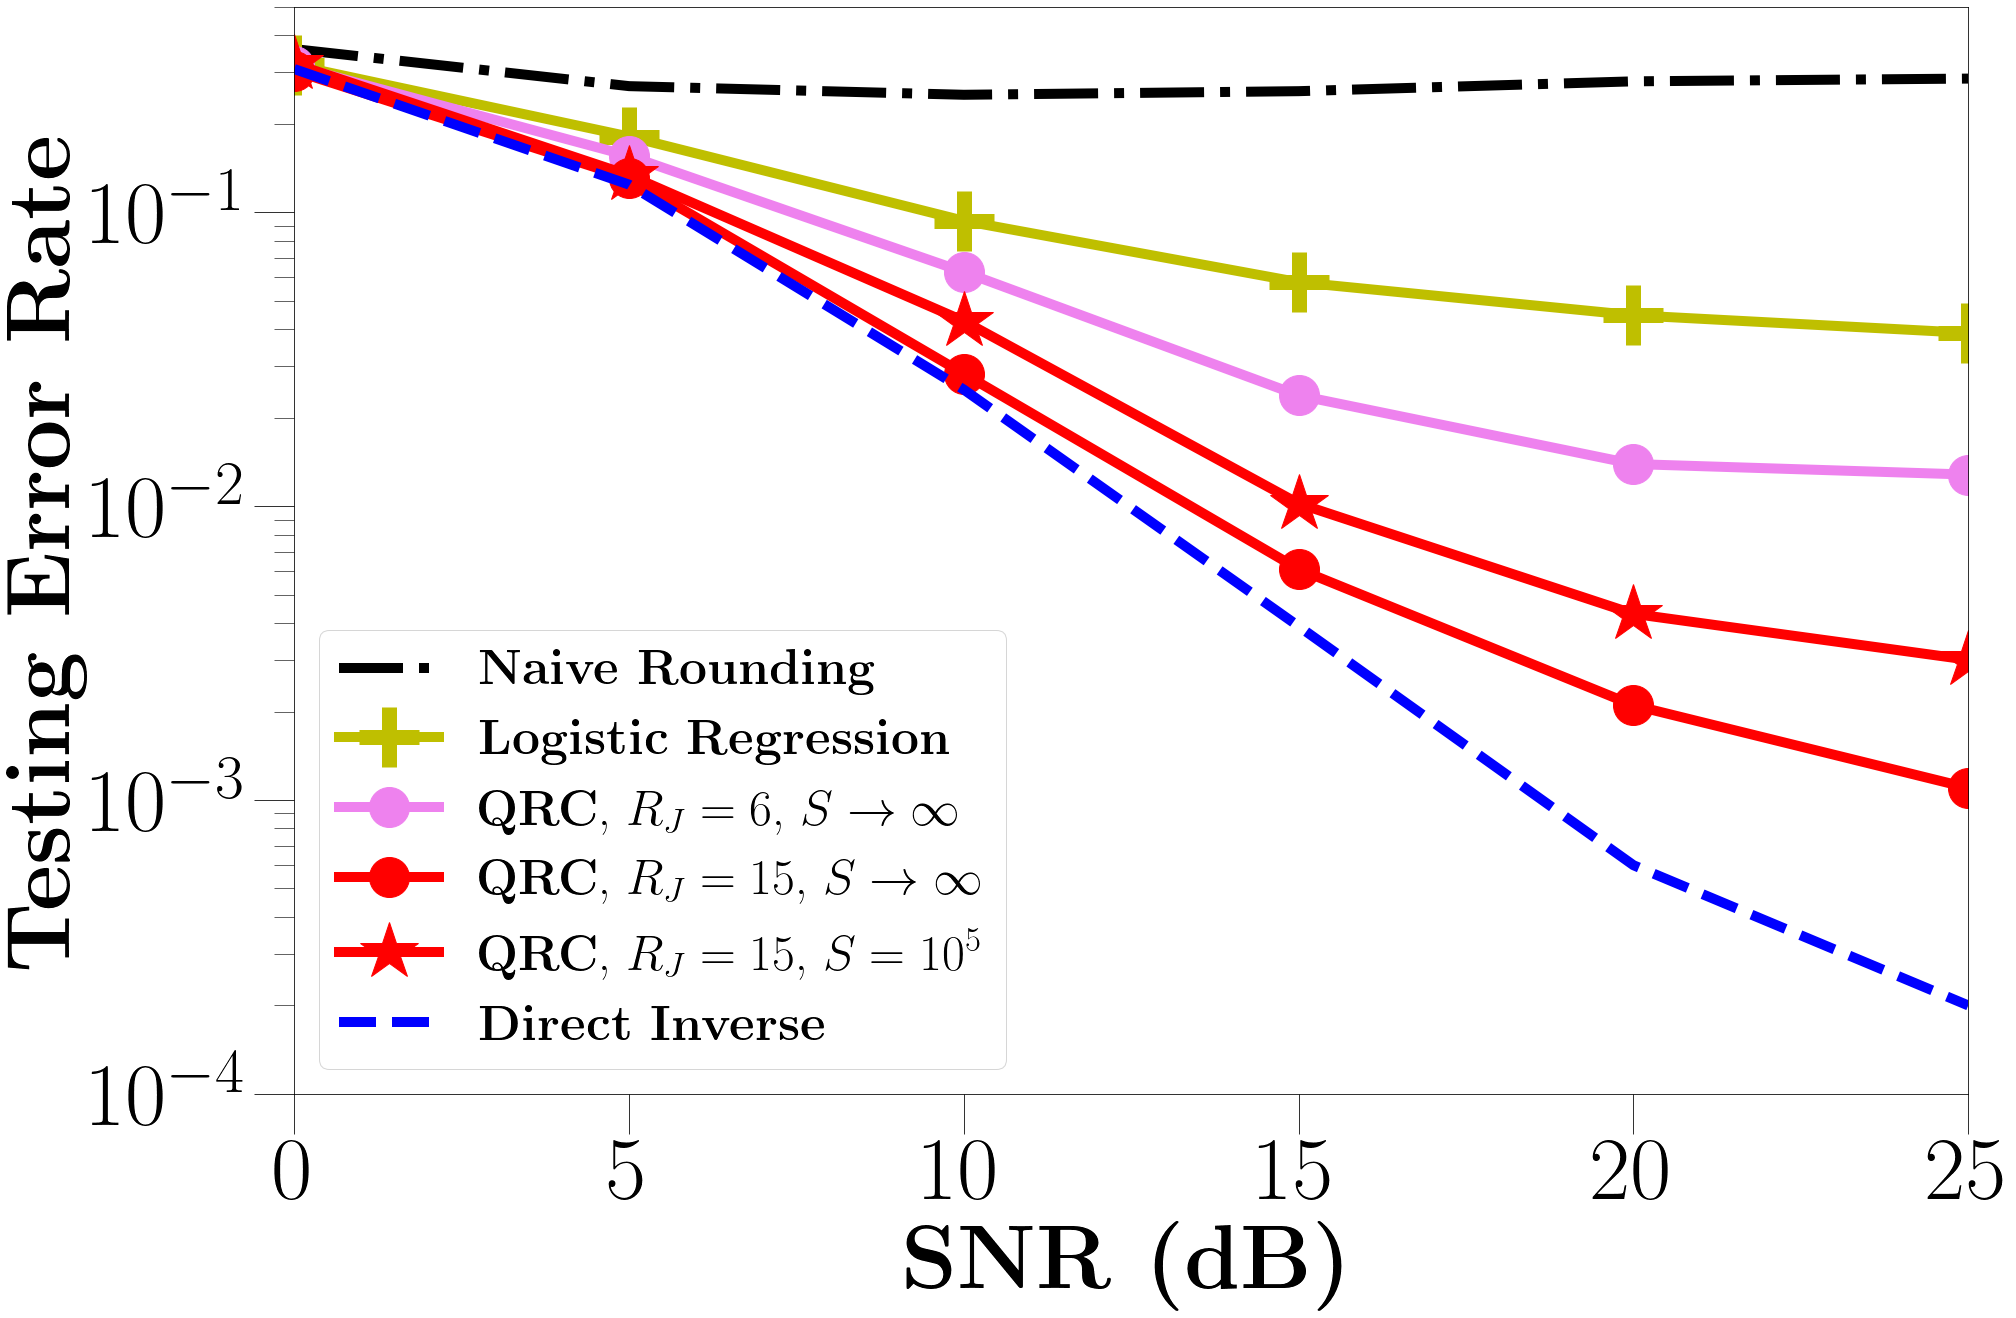

In [72]:
params = {'axes.labelsize': '90',
    'axes.titlesize':'90',
    'xtick.labelsize':'90',
    'ytick.labelsize':'90',
    'lines.linewidth' : 10,
    'legend.fontsize': '40',
    'xtick.major.size': 40.,
    'ytick.major.size': 40.,
    'xtick.minor.size': 20.,
    'ytick.minor.size': 20.,
    }
plt.rcParams.update(params) 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#1f77b4", "#2ca02c","#8c564b", "#bcbd22", "#d62728",  
                                                    "#9467bd","#e377c2", "#7f7f7f", "#17becf", "#ff7f0e"])

## Data Stored

Error_list_QRC_Connected_train = np.array([0.294 , 0.1313, 0.0305, 0.0047, 0.0010, 0.0009])
Error_list_QRC_Connected_test  = np.array([0.3027, 0.1305, 0.0282, 0.0061, 0.0021, 0.0011])

Error_list_QRC_22_train = np.array([0.3094, 0.157 , 0.0548, 0.0232, 0.0134, 0.0100])
Error_list_QRC_22_test  = np.array([0.3146, 0.1554, 0.0626, 0.0238, 0.0139, 0.0128])

Error_list_QRC_Connected_train_S = np.array([0.3087, 0.1419, 0.0386, 0.0088, 0.0028, 0.0014])
Error_list_QRC_Connected_test_S  = np.array([0.3197, 0.1336, 0.0426, 0.0102, 0.0043, 0.0030])

Rounding_list = np.array([0.35883333, 0.2684, 0.25083333, 0.25803333, 0.2787, 0.28476667])
Error_list_test_LR = np.array([0.3166, 0.18083333, 0.09346667, 0.05776667, 0.0446, 0.03883333])
ErrorRate_Bound = np.array([0.3069, 0.1241, 0.0249, 0.0039, 0.0006, 0.0002])

# Plot Figure

SNR_list = np.linspace(0, 25, 6)
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.plot(SNR_list, Rounding_list, 'k-.', label = r'\textbf{Naive Rounding}')
ax.plot(SNR_list, Error_list_test_LR, 'y-+', markersize = 60, markeredgewidth = 15, label = r'\textbf{Logistic Regression}')

ax.plot(SNR_list, Error_list_QRC_22_test, color='violet' , linestyle='-', marker='.', markersize = 80,
        label = r'\textbf{QRC}, $R_J=6$, $S\to\infty$')
ax.plot(SNR_list, Error_list_QRC_Connected_test, color='red',   linestyle='-', marker='.', markersize = 80,
        label = r'\textbf{QRC}, $R_J=15$, $S\to\infty$')
ax.plot(SNR_list, Error_list_QRC_Connected_test_S, color='red', linestyle='-', marker='*', markersize = 60,
        label = r'\textbf{QRC}, $R_J=15$, $S=10^5$')


ax.plot(SNR_list[:6], ErrorRate_Bound[:6], 'b--', label = r'\textbf{Direct Inverse}', markersize = 60)


ax.set_xlim([0, 25])
plt.yscale("log")
ax.set_ylim([0.0001, 0.5])
ax.set_ylabel(r'\textbf{Testing Error Rate}')
ax.set_xlabel(r'\textbf{SNR (dB)}')
ax.legend(ncol = 1, fontsize = 50)
